# Predicting the Best Locations for Iowa Liquor Stores

Here I intend to identify good locations for a new liquor store in Iowa.  Based on a data set covering 2015 from the Iowa liquor board [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy), I indend to identify the optimal cities, counties, and zip codes for liquor sales.  In doing 

# Data Cleaning

In [5]:
# Import numpy and pandas
import numpy as np
import pandas as pd

# Below is basic data cleaning.  Redundant columns are removed, string-typed dollar values are converted to floats,
# and numeric categorical values are converted to integers.

## Load the data into a DataFrame
liquor_sales = pd.read_csv("Iowa_Liquor_sales_sample_10pct.csv")
#liquor_sales = pd.read_csv("Iowa_Liquor_Sales_2015.csv")

## Transform the dates if needed, e.g.
liquor_sales["Date"] = pd.to_datetime(liquor_sales["Date"], format="%m/%d/%Y")

#liquor_sales.head(20)
#print(pd.to_datetime(liquor_sales["Date"].ix[0], format="%m/%d/%Y"))

# Remove redundant columns
del liquor_sales["Category Name"]
del liquor_sales["Item Description"]
#del liquor_sales["County"]
del liquor_sales["County Number"]

# Remove the '$' in front of dollar values and convert the values to floats
for colname in ["State Bottle Cost","State Bottle Retail","Sale (Dollars)"]:
    liquor_sales[colname] = liquor_sales[colname].apply(lambda val: float(val[1:]))

# A small number of zip code fields contain non-numeric values, so set them to nan
def tryint(val):
    try:
        return int(val)
    except ValueError:
        return np.nan
    
liquor_sales["Zip Code"] = liquor_sales["Zip Code"].apply(tryint)

# Less than 1% of any column contains NA values, so dropping all NA's should not significantly affect the analysis
liquor_sales.dropna(inplace=True)

# Re-type the 'Category', 'County Number', and 'Zip Code' columns to integers
for colname in ["Category", "Zip Code"]:
    liquor_sales[colname] = liquor_sales[colname].astype(int)
    
# We are only interested in stores that existed at the beginning of fiscal year 2015 and survived through the year
store_date_ranges = liquor_sales.groupby(["Store Number"])["Date"].agg(["min","max"])
survived_stores = store_date_ranges[(store_date_ranges["max"] > pd.Timestamp("20151001")) &
                                    (store_date_ranges["min"] < pd.Timestamp("20150301"))].index

liquor_sales = liquor_sales[liquor_sales["Store Number"].isin(survived_stores)]

print(liquor_sales.info())
liquor_sales.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256511 entries, 0 to 270954
Data columns (total 15 columns):
Date                     256511 non-null datetime64[ns]
Store Number             256511 non-null int64
City                     256511 non-null object
Zip Code                 256511 non-null int64
County                   256511 non-null object
Category                 256511 non-null int64
Vendor Number            256511 non-null int64
Item Number              256511 non-null int64
Bottle Volume (ml)       256511 non-null int64
State Bottle Cost        256511 non-null float64
State Bottle Retail      256511 non-null float64
Bottles Sold             256511 non-null int64
Sale (Dollars)           256511 non-null float64
Volume Sold (Liters)     256511 non-null float64
Volume Sold (Gallons)    256511 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(7), object(2)
memory usage: 31.3+ MB
None


,Date,Store Number,City,Zip Code,County,Category,Vendor Number,Item Number,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters),Volume Sold (Gallons)
0,2015-11-04,3717,SUMNER,50674,Bremer,1051100,55,54436,750,4.50,6.75,12,81.00,9.0,2.38
1,2016-03-02,2614,DAVENPORT,52807,Scott,1011100,395,27605,750,13.75,20.63,2,41.26,1.5,0.40
2,2016-02-11,2106,CEDAR FALLS,50613,Black Hawk,1011200,65,19067,1000,12.59,18.89,24,453.36,24.0,6.34
3,2016-02-03,2501,AMES,50010,Story,1071100,395,59154,1750,9.50,14.25,6,85.50,10.5,2.77
4,2015-08-18,3654,BELMOND,50421,Wright,1031080,297,35918,1750,7.20,10.80,12,129.60,21.0,5.55


# Initial Data Analysis

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### The data set has 15 columns and 269625 rows of non-null data.  Of these, the columns fall into several rough categories:

#### Numerical sales data

Bottle Volume (ml), State Bottle Cost, State Bottle Retail, Bottles Sold, Sale (Dollars), Volume Sold (Liters), Volume Sold (Gallons)

#### Categorical data for liquor

Category, Vendor Number, Item Number

#### Categorical data for stores

Store Number, City, Zip Code, County Number, Category

#### Date of sale

Date

### Our initial interest is in sales based on "location, price per bottle, total bottles sold".  It is worth noting that the data set does not provide the retail sale price of liqour -- it must be inferred from other data.

The ratio of the between the "State Bottle Retail" value (the cost to the liquor store) and the "State Bottle Cost" value (the cost to the state) is 1.5 for nearly all cases.  Less than 1% of values lie more than 5% from this value.  As such, the two columns are redundant, and there is effectively only one price for liquor sold.

As such, I will use the "State Bottle Retail" (wholesale) price as a proxy for the store profits, assuming a universal markup.  Since I consider only stores which survived the year, I assume that there is a correspondence between orders and sales.  In making this assumption, I neglect the possibility of greater waste for different types of liquor.

Portion of ratios more than 5% away from the typical 50% mark-up : 0.80%


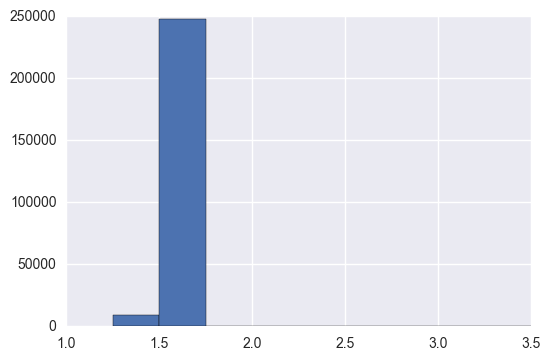

In [7]:
liquor_sales["Cost Ratio"] = liquor_sales["State Bottle Retail"] / liquor_sales["State Bottle Cost"]
liquor_sales["Cost Ratio"].hist()
print "Portion of ratios more than 5% away from the typical 50% mark-up : {0:.2f}%".format( 100. * \
                                  liquor_sales[(liquor_sales["Cost Ratio"] > 1.5*1.05) 
                                               | (liquor_sales["Cost Ratio"] < 1.5*.95)].shape[0] \
                                         / float(liquor_sales.shape[0]))

#### Beyond the existing price data, including the price per liter (PPL) should allow better per-unit comparison across all liquors than price per bottle.

In [8]:
liquor_sales["PPL"] = liquor_sales["Sale (Dollars)"] / liquor_sales["Volume Sold (Liters)"]

#### I also want to cross-validate the data during the analysis.  As such, I will perform analysis only on 2015 data, and use 2016 data for validation.

In [9]:
liquor_2015 = liquor_sales[liquor_sales["Date"] < pd.Timestamp("20160101")]
liquor_2016 = liquor_sales[liquor_sales["Date"] >= pd.Timestamp("20160101")]

#### Using this data, we are interested in the aggregated data for each store.  Aggregating the sensible numeric, non-redundant columns and taking several per-store averages gives the following data for 2015.

As stated before, the per-bottle state and wholesale costs are redundant, as are several of the other columns which are the combination of other columns.  On a fundamental level, the only totals which are relevant are the total wholesale cost, number of bottles, and total liquor volume.  The "stores_summary_2015" dataframe contains these three totals for each store and the six combination ratios taken from any two and considering both as possible numerators/denominators.  I also scale the columns to make the numbers easier to read.

In [10]:
stores_summary_2015 = liquor_2015[["Store Number","Sale (Dollars)",
                                   "Bottles Sold","Volume Sold (Liters)"]].groupby("Store Number").agg(sum)
stores_summary_2015["Store Number"] = stores_summary_2015.index
stores_summary_2015 = stores_summary_2015[["Store Number","Sale (Dollars)",
                                           "Bottles Sold","Volume Sold (Liters)"]]
stores_summary_2015["Sale (Dollars)"] /= 1000
stores_summary_2015["Bottles Sold"] /= 1000
stores_summary_2015["Volume Sold (Liters)"] /= 1000
stores_summary_2015.columns = ["Store Number","Sale (Thousand Dollars)","Bottles Sold (Thousands)","Volume Sold (kL)"]
stores_summary_2015["Dollars Per Liter"] = stores_summary_2015["Sale (Thousand Dollars)"] \
                                / stores_summary_2015["Volume Sold (kL)"]
stores_summary_2015["Liters Per Dollar"] = 1 / stores_summary_2015["Dollars Per Liter"]
stores_summary_2015["Average Bottle Cost ($)"] = stores_summary_2015["Sale (Thousand Dollars)"] \
                                / stores_summary_2015["Bottles Sold (Thousands)"]
stores_summary_2015["Bottles Per Dollar"] = 1 / stores_summary_2015["Average Bottle Cost ($)"]
stores_summary_2015["Average Bottle Volume (L)"] = stores_summary_2015["Volume Sold (kL)"] \
                                / stores_summary_2015["Bottles Sold (Thousands)"]
stores_summary_2015["Bottles Per L"] = 1 / stores_summary_2015["Average Bottle Volume (L)"]
stores_summary_2015.sort_values(ascending=False, by="Sale (Thousand Dollars)",inplace=True)

In [11]:
stores_summary_2015.head(5)

,Store Number,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL),Dollars Per Liter,Liters Per Dollar,Average Bottle Cost ($),Bottles Per Dollar,Average Bottle Volume (L),Bottles Per L
Store Number,,,,,,,,,,
2633,2633,1000.78330,62.923,61.90975,16.165197,0.061861,15.904889,0.062874,0.983897,1.016367
4829,4829,878.81270,52.681,50.79274,17.301935,0.057797,16.681777,0.059946,0.964157,1.037176
3385,3385,441.98355,27.363,31.56300,14.003217,0.071412,16.152598,0.061910,1.153492,0.866933
2512,2512,419.74683,27.692,25.92188,16.192762,0.061756,15.157693,0.065973,0.936078,1.068287
3420,3420,352.02066,20.868,25.14300,14.000742,0.071425,16.868922,0.059281,1.204859,0.829973


In [12]:
stores_summary_2015.tail(5)

,Store Number,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL),Dollars Per Liter,Liters Per Dollar,Average Bottle Cost ($),Bottles Per Dollar,Average Bottle Volume (L),Bottles Per L
Store Number,,,,,,,,,,
5047,5047,0.79506,0.036,0.03600,22.085000,0.045280,22.085000,0.045280,1.000000,1.000000
4996,4996,0.75642,0.078,0.04200,18.010000,0.055525,9.697692,0.103117,0.538462,1.857143
4858,4858,0.71153,0.072,0.04315,16.489687,0.060644,9.882361,0.101190,0.599306,1.668598
3677,3677,0.57351,0.048,0.05625,10.195733,0.098080,11.948125,0.083695,1.171875,0.853333
4929,4929,0.52824,0.084,0.04500,11.738667,0.085189,6.288571,0.159019,0.535714,1.866667


### Restriction to Likely Liquor Stores

Looking at the summary table, the lowest volume "liquor stores" have very small volume orderer -- those in the bottom five in terms of total orders each ordered less than a hundred bottles of liquor for less that a thousand total dollars in wholesale price.  While these may indeed by alcohol sellers with liquor licenses, the business case here is to produce advice on locations for a true liquor store.

As such, I will consider a reduced sub-set of the data, in particular stores which ordered at least 500 bottles or $5,000 worth of liquor.  Along with the "good stores" criterion applied above to ensure the stores were open the entire year, this should restrict the set to stores for which liquor provides significant income.

In [13]:
#stores_summary_2015 = stores_summary_2015[(stores_summary_2015["Bottles Sold (Thousands)"] > 0.5) | 
#                    (stores_summary_2015["Sale (Thousand Dollars)"] > 5)]

#### Paired scatter plots of aggregated data

The paired plots of the aggregated columns show a high degree of correlation between total wholesale costs, bottles sold, and total liquor volume.  These three values thus have high predictive value for one another, but none are useful for business planning -- the relation boils down to "if you seel more liquor, you get more money".  The intrinsic ratio combinations may, however, provide more predictive power in a manner useful to a prospective liquor store.  The "Liters Per Dollar" and "Average Bottle Volume" columns in particular have generally better results in middle ranges, and thus may be useful predictors for what types of liquor to stock.

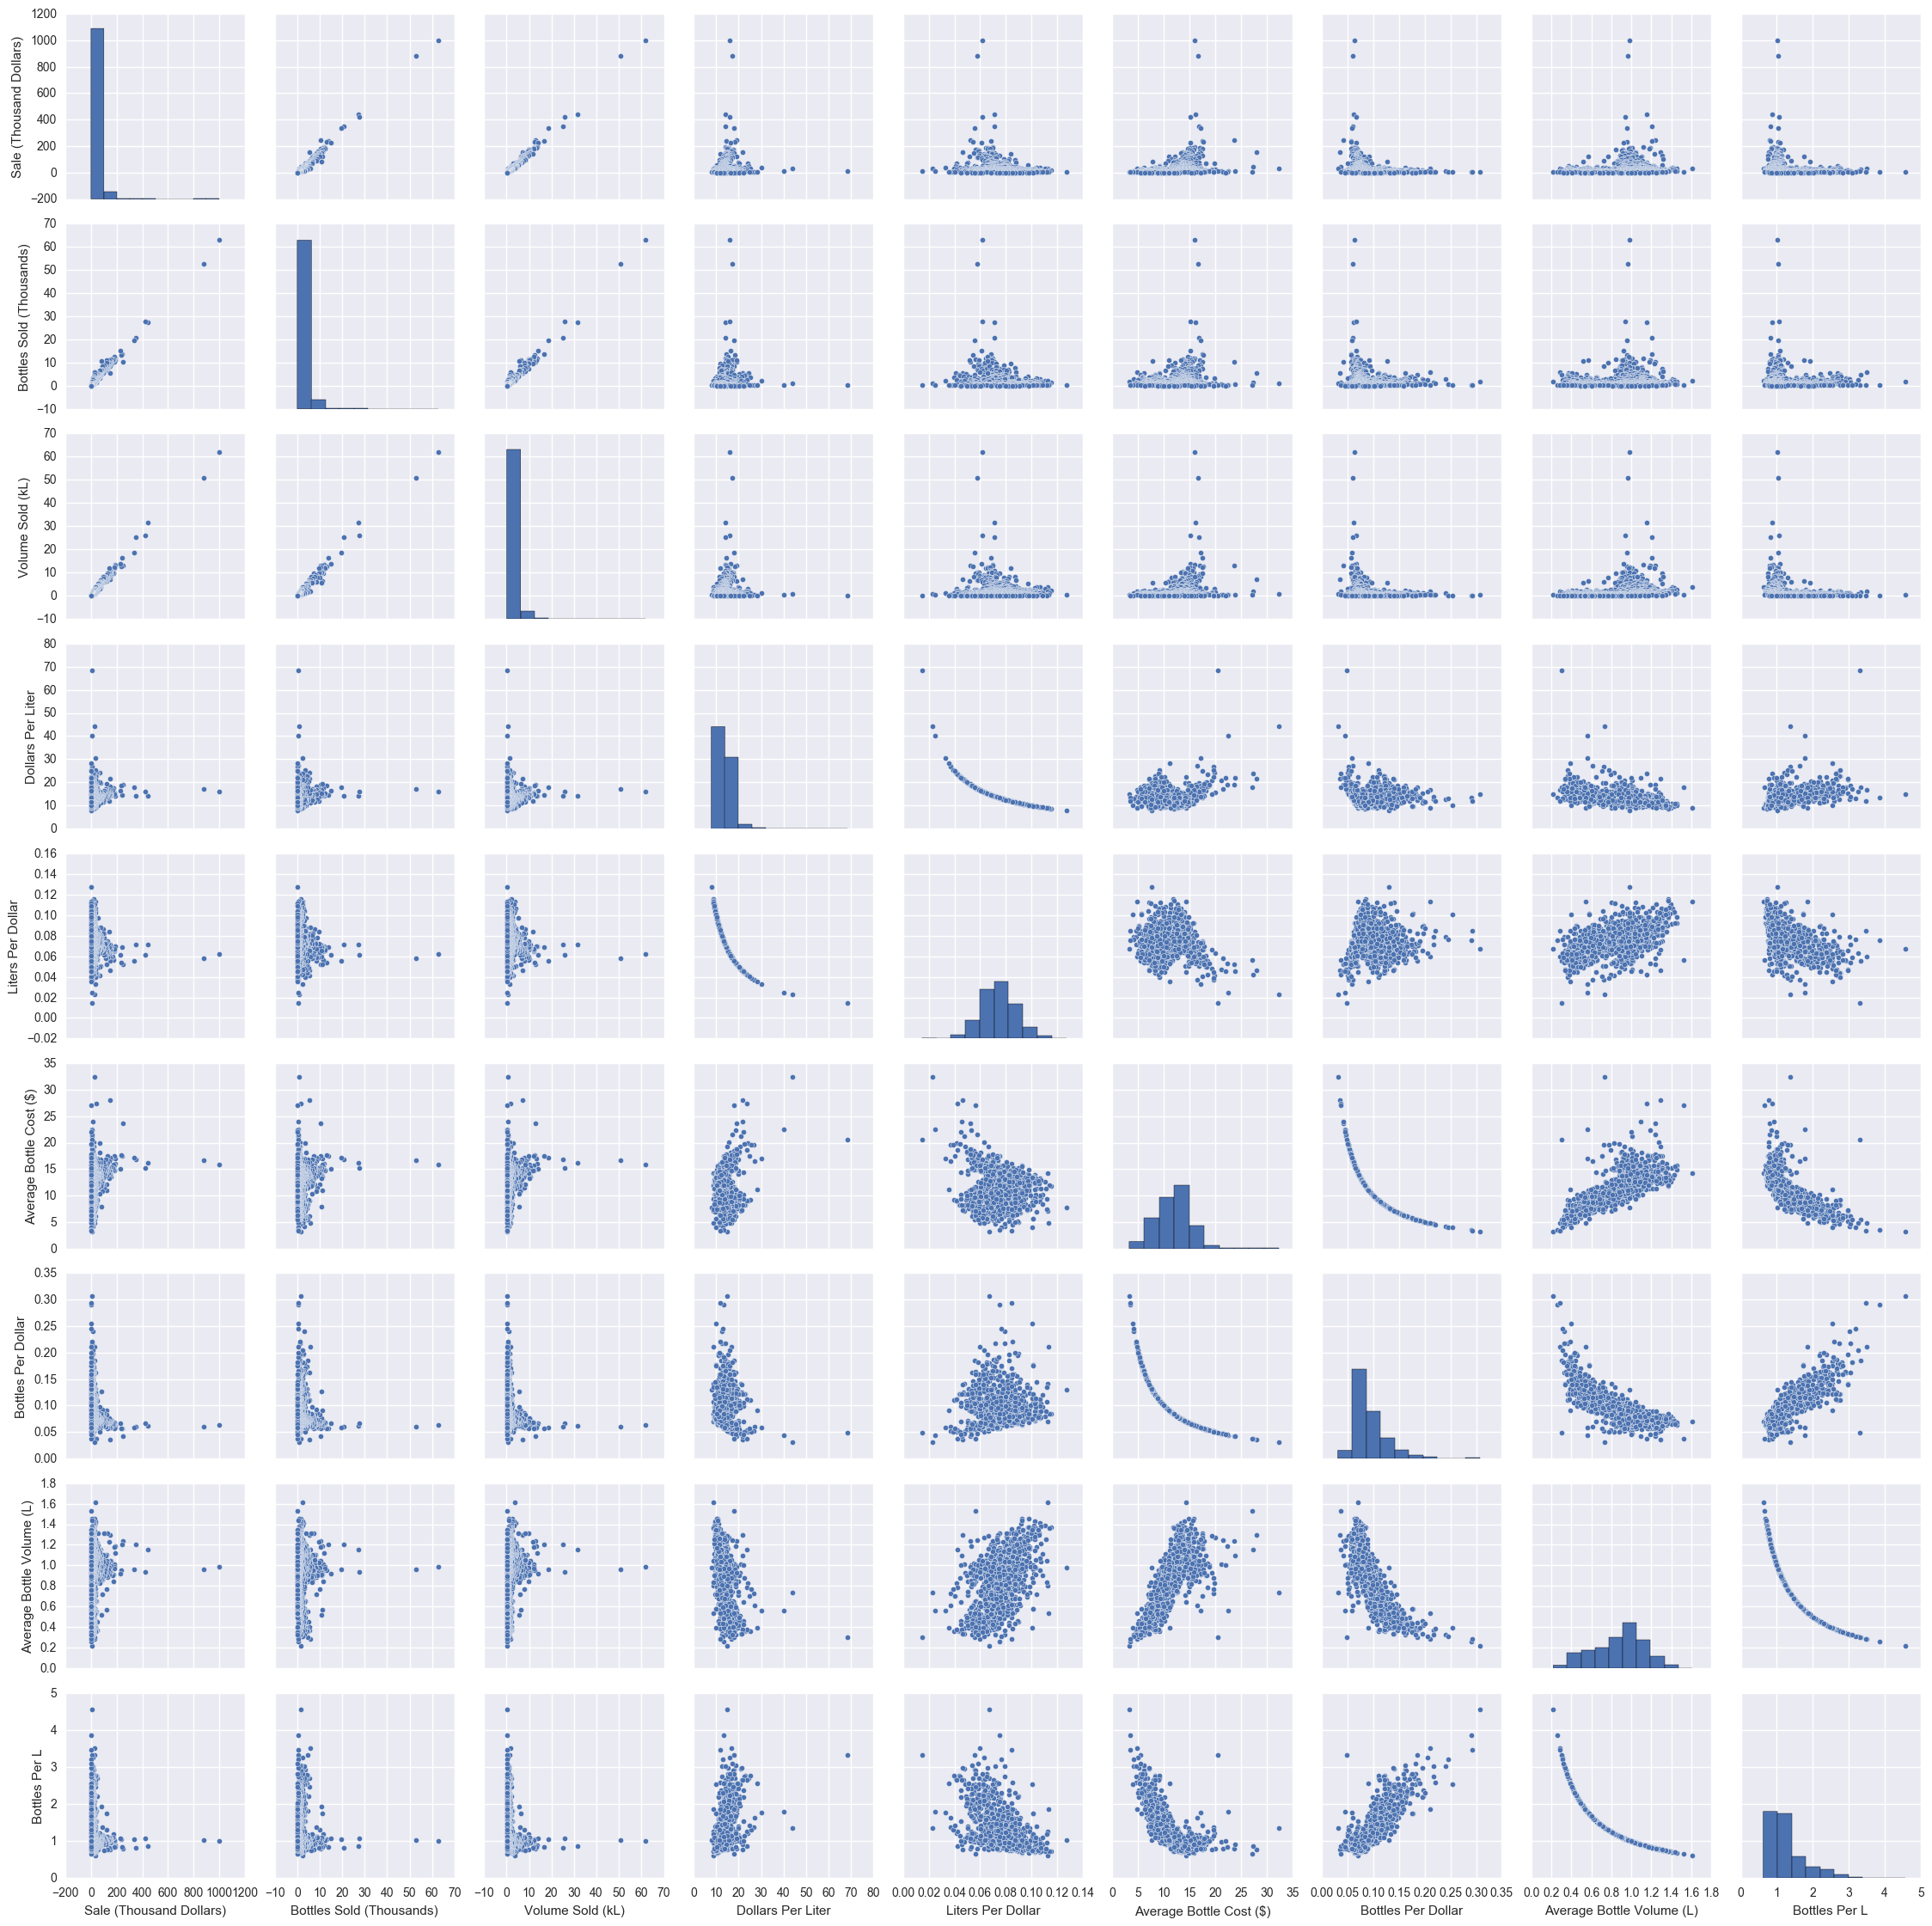

In [14]:
sns.pairplot(stores_summary_2015.iloc[:,range(1,10)])

#### Location Inclusion

The location of the store is also important, so I add the location information to the data frame.

In [15]:
store_locations = liquor_2015[["Store Number","City","Zip Code","County"]].groupby("Store Number").agg("first")
store_locations["Store Number"] = store_locations.index
store_locations = store_locations[["Store Number","City","Zip Code","County"]]
store_data_2015 = pd.merge(store_locations, stores_summary_2015,on="Store Number")

store_data_2015.head()

,Store Number,City,Zip Code,County,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL),Dollars Per Liter,Liters Per Dollar,Average Bottle Cost ($),Bottles Per Dollar,Average Bottle Volume (L),Bottles Per L
0,2106,CEDAR FALLS,50613,Black Hawk,146.32622,10.367,9.73185,15.035807,0.066508,14.114616,0.070849,0.938733,1.065265
1,2113,GOWRIE,50543,Webster,9.31022,0.671,0.65985,14.109601,0.070874,13.875142,0.072071,0.983383,1.016898
2,2130,WATERLOO,50703,Black Hawk,111.87143,7.430,6.89137,16.233554,0.061601,15.056720,0.066416,0.927506,1.078160
3,2152,ROCKWELL,50469,Cerro Gordo,7.72108,0.573,0.63337,12.190473,0.082031,13.474834,0.074212,1.105358,0.904684
4,2178,WAUKON,52172,Allamakee,24.32418,1.928,1.91712,12.687876,0.078815,12.616276,0.079263,0.994357,1.005675


### Largest and Smallest Average Sales for Counties, Cities, and Zip Codes

In [16]:
county_data_2015 = store_data_2015.groupby("County")[["Sale (Thousand Dollars)","Bottles Sold (Thousands)",
                                                             "Volume Sold (kL)"]].mean()
county_data_2015["County"] = county_data_2015.index
county_data_2015["Number of Stores"] = store_data_2015.groupby("County")["Store Number"].agg("count")
county_data_2015 = county_data_2015[["County","Number of Stores",
                                     "Sale (Thousand Dollars)","Bottles Sold (Thousands)",
                                     "Volume Sold (kL)"]].sort_values(ascending=False,by="Sale (Thousand Dollars)")

In [17]:
county_data_2015.head(5)

,County,Number of Stores,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL)
County,,,,,
Dickinson,Dickinson,9,41.294163,2.924667,3.020024
Carroll,Carroll,7,37.762687,2.502571,2.810279
Johnson,Johnson,46,36.001110,2.520587,2.213119
Polk,Polk,165,35.698877,2.614121,2.286915
Scott,Scott,60,33.854110,2.770433,2.208793


In [18]:
county_data_2015.tail(5)

,County,Number of Stores,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL)
County,,,,,
Grundy,Grundy,7,4.176279,0.371143,0.361820
Butler,Butler,7,3.645196,0.319571,0.333094
Decatur,Decatur,5,3.085892,0.284800,0.231532
Audubon,Audubon,1,2.869680,0.276000,0.273000
Fremont,Fremont,1,2.654450,0.314000,0.187100


In [19]:
city_data_2015 = store_data_2015.groupby("City")[["Sale (Thousand Dollars)","Bottles Sold (Thousands)",
                                                  "Volume Sold (kL)"]].mean()
city_data_2015["City"] = city_data_2015.index
city_data_2015["Number of Stores"] = store_data_2015.groupby("City")["Store Number"].agg("count")
city_data_2015 = city_data_2015[["City","Number of Stores",
                                 "Sale (Thousand Dollars)","Bottles Sold (Thousands)",
                                 "Volume Sold (kL)"]].sort_values(ascending=False,by="Sale (Thousand Dollars)")

In [20]:
city_data_2015.head(5)

,City,Number of Stores,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL)
City,,,,,
MILFORD,MILFORD,1,134.773700,9.4820,9.740310
WINDSOR HEIGHTS,WINDSOR HEIGHTS,5,103.359014,6.5660,7.251918
MOUNT VERNON,MOUNT VERNON,2,98.607235,6.6855,6.579350
OTTUWMA,OTTUWMA,1,61.929580,4.6200,4.136870
CARROLL,CARROLL,4,60.769557,3.9500,4.524505


In [21]:
city_data_2015.tail(5)

,City,Number of Stores,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL)
City,,,,,
GOLDFIELD,GOLDFIELD,1,1.02624,0.096,0.08400
VILLISCA,VILLISCA,1,1.02050,0.101,0.08175
WHEATLAND,WHEATLAND,1,0.89404,0.081,0.07812
LOVILIA,LOVILIA,1,0.81244,0.092,0.04815
EVERLY,EVERLY,1,0.57351,0.048,0.05625


In [22]:
zip_data_2015 = store_data_2015.groupby("Zip Code")[["Sale (Thousand Dollars)","Bottles Sold (Thousands)",
                                                     "Volume Sold (kL)"]].mean()
zip_data_2015["Zip Code"] = zip_data_2015.index
zip_data_2015["Number of Stores"] = store_data_2015.groupby("Zip Code")["Store Number"].agg("count")
zip_data_2015 = zip_data_2015[["Zip Code","Number of Stores",
                               "Sale (Thousand Dollars)","Bottles Sold (Thousands)",
                               "Volume Sold (kL)"]].sort_values(ascending=False,by="Sale (Thousand Dollars)")

In [23]:
zip_data_2015.head(5)

,Zip Code,Number of Stores,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL)
Zip Code,,,,,
50314,50314,4,260.603923,17.106500,14.750155
51351,51351,1,134.773700,9.482000,9.740310
50320,50320,9,119.006648,7.721556,7.382862
52411,52411,1,113.193970,6.745000,6.584190
52314,52314,2,98.607235,6.685500,6.579350


In [24]:
zip_data_2015.tail(5)

,Zip Code,Number of Stores,Sale (Thousand Dollars),Bottles Sold (Thousands),Volume Sold (kL)
Zip Code,,,,,
50542,50542,1,1.02624,0.096,0.08400
50864,50864,1,1.02050,0.101,0.08175
52777,52777,1,0.89404,0.081,0.07812
50150,50150,1,0.81244,0.092,0.04815
51338,51338,1,0.57351,0.048,0.05625


## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

In [25]:
import patsy
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [26]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
kf = KFold(n_splits=10, shuffle=True, random_state=187)

In [27]:
# I will use the total sales as the target variable in all cases
y = store_data_2015["Sale (Thousand Dollars)"] 

# The relevant values are 
store_models = [[],
#                ["Liters Per Dollar","Average Bottle Volume (L)"],
                ["Dollars Per Liter","Liters Per Dollar",
                 "Average Bottle Cost ($)","Bottles Per Dollar",
                 "Average Bottle Volume (L)","Bottles Per L"]]

category_models = [["County"],["Zip Code"],["City"],
                   ["Zip Code","County"],["Zip Code","City"],["City","County"],
                   ["Zip Code","County","City"]]

model_results = []

for category_columns in category_models:
    for store_specific_values in store_models:
        X = store_data_2015[category_columns + store_specific_values]
        X = pd.get_dummies(X,columns=category_columns)
        X = sm.add_constant(X, prepend=False)
        outof_sample = []
        in_sample = []
        for train_index, test_index in kf.split(X):
            X_train = X.iloc[train_index]
            y_train = y.iloc[train_index]

            model = sm.OLS(y_train, X_train).fit()
            in_sample.append(r2_score( y_train,model.predict(X_train)))

            X_test = X.iloc[test_index]
            y_test = y.iloc[test_index]

            outof_sample.append(r2_score(y_test,model.predict(X_test)))
            
        X_train = X
        y_train = y
        model = sm.OLS(y_train, X_train).fit()
        coefficients = pd.DataFrame(model.params, model.params.index)
        coefficients.columns = ["Coefficient"]
        coefficients["Names"] = coefficients.index
        coefficients.sort_values(inplace=True,ascending=False,by="Coefficient")
        coefficients = coefficients[coefficients["Names"] != "const"]
        coefficients = coefficients[coefficients["Names"].isin(store_specific_values) == False]

        model_results.append({"Categorical Columns":category_columns,
                              "# Other Columns":len(store_specific_values),
                              "Out of Sample R^2":np.mean(outof_sample),
                              "In Sample R^2":np.mean(in_sample),
                              "Locations Best to Worst":list(coefficients["Names"])})
    
model_results = pd.DataFrame(model_results).sort_values(ascending=False,by="Out of Sample R^2")
model_results = model_results[["Categorical Columns","# Other Columns",
                              "Out of Sample R^2","In Sample R^2","Locations Best to Worst"]]

In [28]:
model_results

,Categorical Columns,# Other Columns,Out of Sample R^2,In Sample R^2,Locations Best to Worst
1,[County],6,6.876259e-02,0.143038,"[County_Scott, County_Polk, County_Dallas, Cou..."
5,[City],6,-2.650241e-03,0.202156,"[City_MILFORD, City_WINDSOR HEIGHTS, City_MOUN..."
11,"[City, County]",6,-7.391629e-03,0.209183,"[City_WINDSOR HEIGHTS, City_DES MOINES, County..."
0,[County],0,-5.413460e-02,0.034158,"[County_Dickinson, County_Carroll, County_John..."
4,[City],0,-1.127506e-01,0.086275,"[City_MILFORD, City_WINDSOR HEIGHTS, City_MOUN..."
10,"[City, County]",0,-1.502760e-01,0.100186,"[City_WINDSOR HEIGHTS, City_DES MOINES, County..."
3,[Zip Code],6,-2.433951e-01,0.296573,"[Zip Code_50314, Zip Code_50320, Zip Code_5135..."
7,"[Zip Code, County]",6,-2.594948e-01,0.305012,"[Zip Code_50314, Zip Code_50320, County_Dallas..."
9,"[Zip Code, City]",6,-2.622257e-01,0.301322,"[Zip Code_50314, Zip Code_50320, City_WEST DES..."
13,"[Zip Code, County, City]",6,-2.706520e-01,0.309160,"[Zip Code_50314, County_Dallas, Zip Code_50320..."


## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.